In [ ]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dataretrieval
import hydrofunctions
#import pygeohydro
#import ulmo
#import wellapplication

import pastas

In [ ]:
os.getcwd()

## hydrofunctions

In [ ]:
dir(hydrofunctions)
help(hydrofunctions)
hydrofunctions.__version__

In [ ]:
fox_river_gb_dv = hydrofunctions.NWIS("040851385", "dv", period="P10D")
print(fox_river_gb_dv)
print(len(fox_river_gb_dv.df().index))

# this is a handy method to look at the response code, maybe useful
print(fox_river_gb_dv.response)

In [ ]:
fox_river_gb_iv = hydrofunctions.NWIS("040851385", "iv", period="P10D")
print(fox_river_gb_iv)
print(len(fox_river_gb_iv.df().index))
print(fox_river_gb_iv.response)

In [ ]:
fox_river_gb_iv = hydrofunctions.NWIS("040851385", "iv", "2021-10-15", "2021-10-25")
print(fox_river_gb_iv)
print(len(fox_river_gb_iv.df().index))
print(fox_river_gb_iv.response)

In [ ]:
fox_river_gb_iv.df()

In [ ]:
wi_code = "WI"
wi = hydrofunctions.NWIS(stateCd=wi_code)
type(wi)

In [ ]:
dir(wi)

## python dataretrieval

In [ ]:
help(dataretrieval)
print(dir(dataretrieval))
#dataretrieval.__version__

In [ ]:
# dataretrivel is broken into modules, need to import individual pieaces as needed
from dataretrieval import nwis, utils

# refernence gage, time, and data
fox_river_gb = "040851385"
start = "2021-10-10"
end = "2021-10-20"
data = ["iv", "dv", "qwdata", "site"]

# attempt to get iv, dv, site, and qwdata... raise error if data does not exist
for d in data:
    try:
        nwis.get_record(sites=fox_river_gb, service=d, start=start, end=end).info()
        print("-"*20)

    except utils.NoSitesError as e:
        print(f"{d}: {e}")
        print("-"*20)

In [ ]:
# use specific dataretrieval functions to get data, these follow R dataRetrieval style
from dataretrieval import nwis

# refernence gage, time, and data
fox_river_gb = "040851385"
start = "2021-10-15"
end = "2021-10-25"

# returns a tuple with dataframe and metadata class
dv = nwis.get_dv(start=start, end=end, sites=fox_river_gb)
iv = nwis.get_iv(start=start, end=end, sites=fox_river_gb)
info = nwis.get_info(sites=fox_river_gb)

In [ ]:
type(dv)
for i in dv:
    print(type(i))

In [ ]:
type(iv)
for i in dv:
    print(type(i))

In [ ]:
type(info)
for i in info:
    print(type(i))

In [ ]:
iv[0].head()

In [ ]:
# pull out info dataframe and transpose
df_info = info[0]
df_info.T.head()

In [ ]:
# pull out metadata class and look at attributes, can't remember a better way to print
meta_info = info[1]
print(meta_info.comment)
print(meta_info.disclaimer)
print(meta_info.header)
print(meta_info.query_time)
print(meta_info.site_info)
print(meta_info.statistic_info)
print(meta_info.url)
print(meta_info.variable_info)

In [ ]:
from dataretrieval import nwis
codes = nwis.get_pmcodes()
codes

In [ ]:
# hydrofunctions and dataretrieval implement datetime indexes differently
print(hf_data.index)
print(dt_data.index)

## test returned data

looking at data returned by hydrofunctions and dataretrieval from a fixed stream gage. how close are the timeseries for a given channel? do the date time indexes align?

In [1]:
import pandas as pd

import dataretrieval
import hydrofunctions

from dataretrieval import nwis

# parameter codes
temp_c = "00010"       # temp celsius
discharge_q = "00060"  # cubic feet per second
gage_height = "00065"  # height

def get_data(gage, data, start, end):
    # retrieve data with hydrofunctions, get dataframe of discharge, convert datetime to CDT
    hf_data = hydrofunctions.NWIS(fox_river_gb, data, start, end).df("discharge").tz_convert('US/Central')
    
    # retrieve data with dataretrieval, query with discharge parameter code, get dataframe tuple
    dt_data = nwis.get_iv(start=start, end=end, sites=fox_river_gb, parameterCd="00060")[0]
    
    return hf_data, dt_data

# refernence gage, time, and data
fox_river_gb = "040851385"
data = "iv"
start = "2021-10-15"
end = "2021-10-25"

hf_df, dt_df = get_data(gage=fox_river_gb, data=data, start=start, end=end)

Requested data from https://waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=040851385&startDT=2021-10-15&endDT=2021-10-25


In [2]:
print(f"hydrofunctions {data} data from {start} to {end}: {len(hf_df.index)} observations")
print(f"dataretrieval {data} data from {start} to {end}: {len(dt_df.index)} observations")
print("-"*50)

# figure out how many records there should be over N days with measurements taken at 15 minute intervals

# hydrofunctions
hf_length = len(hf_df.index)

# dataretrieval
dt_length = len(dt_df.index)

# how many 5 minute observations from 2021-10-15 to 2021-10-25 (10 days)
perhour = 60/5
perday = 24*perhour
perperiod = 10*perday
print(f"observations: 10days = {perperiod}, 1day= {perday}, 1hour= {perhour}")
print("-"*50)

# observation differences
hf_diff = hf_length-perperiod
dt_diff = dt_length-perperiod

def text(diff):
    return "extra hours of observations" if diff >= 0 else "missing hours of observations"

def hours(diff):
    return abs(round(diff/perhour, 2))

print(f"hydrofunctions difference: {abs(hf_diff)} observations, {hours(hf_diff)} {text(hf_diff)}")
print(f"python-dataretrieval difference: {abs(dt_diff)} observations, {hours(dt_diff)} {text(dt_diff)}")

hydrofunctions iv data from 2021-10-15 to 2021-10-25: 3168 observations
dataretrieval iv data from 2021-10-15 to 2021-10-25: 2783 observations
--------------------------------------------------
observations: 10days = 2880.0, 1day= 288.0, 1hour= 12.0
--------------------------------------------------
hydrofunctions difference: 288.0 observations, 24.0 extra hours of observations
python-dataretrieval difference: 97.0 observations, 8.08 missing hours of observations


In [42]:
from datetime import datetime, timedelta

# grab datetime index, run diff on datetimes, drop index row 0 NA
dt_index_delta = dt_df.reset_index()["datetime"].diff()[1:]

# delta between continous timesteps should be 5 minutes, filter for a timedelta greater than 5 minutes
dt_gaps = dt_index_delta[dt_index_diff > timedelta(minutes=5)]

# print results 
print(f'{len(dt_gaps)} gaps with total duration: {dt_gaps.sum()}')
for i, g in dt_gaps.iteritems():
    gap_start = dt_df.reset_index()["datetime"][i - 1]
    gap_stop = dt_df.reset_index()["datetime"][i]
    print(f"Start: {datetime.strftime(gap_start, '%Y-%m-%d %H:%M:%S')} | Stop: {datetime.strftime(gap_stop, '%Y-%m-%d %H:%M:%S')} | Duration: {str(g.to_pytimedelta())}")
    


5 gaps with total duration: 1 days 08:30:00
Start: 2021-10-19 19:20:00 | Stop: 2021-10-19 20:25:00 | Duration: 1:05:00
Start: 2021-10-21 12:15:00 | Stop: 2021-10-21 13:00:00 | Duration: 0:45:00
Start: 2021-10-21 13:00:00 | Stop: 2021-10-22 01:00:00 | Duration: 12:00:00
Start: 2021-10-22 01:00:00 | Stop: 2021-10-22 13:00:00 | Duration: 12:00:00
Start: 2021-10-22 13:00:00 | Stop: 2021-10-22 19:40:00 | Duration: 6:40:00


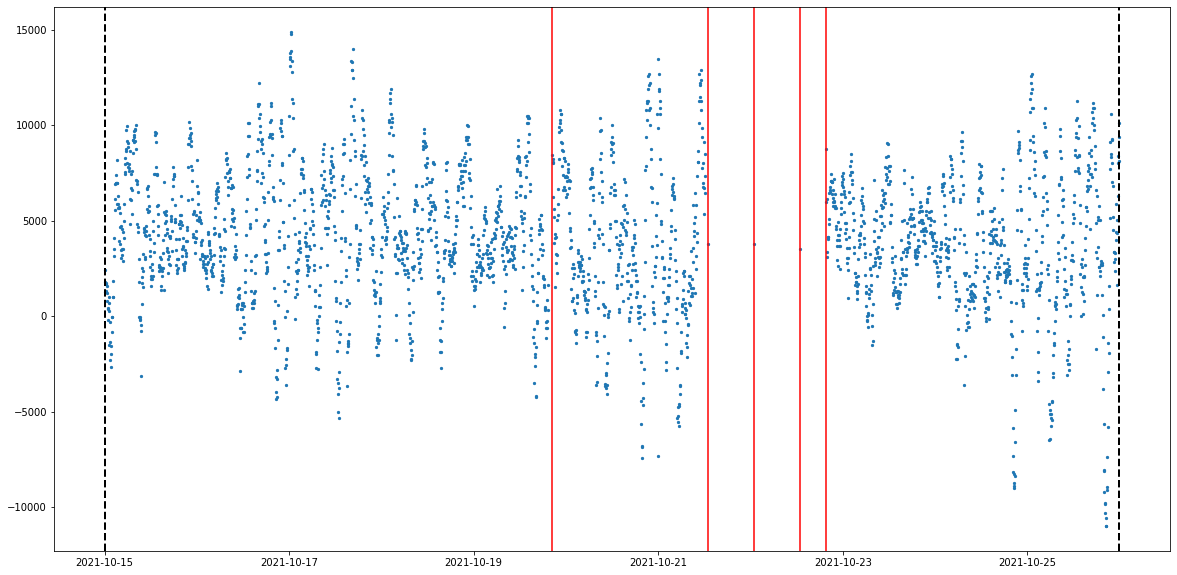

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# convert index to numpy array, datetime object preserved
dt_np = dt_df.index.to_numpy()

# compute time diff, drops first index due to diff algro 
dt_np_delta = np.diff(dt_np)

# insert dummy diff at index 0 to align indexes
dt_np_delta = np.insert(dt_np_delta, 0, dt_np_delta[0])

# get boolean mask for timedelta over 5 minutes
dt_np_mask = dt_np_delta > timedelta(minutes=5)

# filter original dataframe with mask to extract datetime indexes with missing data
dt_np_gaps = dt_df[dt_np_mask]

# plot it
plt.figure(figsize=(20, 10))
plt.scatter(dt_df.index, dt_df["00060_2"], s=5)
plt.axvline(dt_df.index[0], color="black", linestyle="--", linewidth=2)
plt.axvline(dt_df.index[-1], color="black", linestyle="--", linewidth=2)
for i in dt_np_gaps.index.to_list():
    plt.axvline(i, color="red")
plt.show()

In [71]:
dt_np_gaps

[Timestamp('2021-10-19 20:25:00-0500', tz='pytz.FixedOffset(-300)'),
 Timestamp('2021-10-21 13:00:00-0500', tz='pytz.FixedOffset(-300)'),
 Timestamp('2021-10-22 01:00:00-0500', tz='pytz.FixedOffset(-300)'),
 Timestamp('2021-10-22 13:00:00-0500', tz='pytz.FixedOffset(-300)'),
 Timestamp('2021-10-22 19:40:00-0500', tz='pytz.FixedOffset(-300)')]

In [17]:
dt_index_diff

1      0 days 00:05:00
2      0 days 00:05:00
3      0 days 00:05:00
4      0 days 00:05:00
5      0 days 00:05:00
             ...      
2778   0 days 00:05:00
2779   0 days 00:05:00
2780   0 days 00:05:00
2781   0 days 00:05:00
2782   0 days 00:05:00
Name: datetime, Length: 2782, dtype: timedelta64[ns]

In [ ]:
# look at dataframe info
print(hf_df.info())
print("-*"*40)
print(dt_df.info())

In [ ]:
hf_df.head()

In [74]:
dt_df.tail()

,00060_2,00060_2_cd,site_no
datetime,,,
2021-10-25 23:35:00-05:00,8410.0,P,040851385
2021-10-25 23:40:00-05:00,8040.0,P,040851385
2021-10-25 23:45:00-05:00,9370.0,P,040851385
2021-10-25 23:50:00-05:00,10100.0,P,040851385
2021-10-25 23:55:00-05:00,8140.0,P,040851385


In [ ]:
# look at first time step
print(hf_df.index[1], hf_df.iloc[0].tolist())
print(dt_df.index[1], dt_df.iloc[0].tolist())

# look at last time step
print(hf_df.index[-1], hf_df.iloc[-1].tolist())
print(dt_df.index[-1], dt_df.iloc[-1].tolist())

In [ ]:
print("parameter code:",dt_df.columns[1])
dt_df.iloc[:,1]

In [ ]:
dt_df.iloc[:,1].unique()